## Setup, Loading Data and CDFs

In [7]:
DATA_NAME = 'batch1approx1e5-agriVision-fourier-gray' # size-name-transform-channel

In [8]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/fourier/batch1approx1e5/gray'

In [9]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [10]:
path = dict()
path['transform'] = 'fourier'

In [11]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000}

In [12]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [13]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [14]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:47<00:00, 2119.65it/s]


Band 5


100%|██████████| 100000/100000 [00:46<00:00, 2162.45it/s]


Band 8


100%|██████████| 100000/100000 [00:45<00:00, 2205.94it/s]


Band 11


100%|██████████| 100000/100000 [00:45<00:00, 2219.25it/s]


Band 14


100%|██████████| 100000/100000 [00:45<00:00, 2209.86it/s]


Band 17


100%|██████████| 100000/100000 [00:45<00:00, 2211.86it/s]


Band 20


100%|██████████| 100000/100000 [00:45<00:00, 2201.02it/s]


Band 23


100%|██████████| 100000/100000 [00:46<00:00, 2141.91it/s]


Band 26


100%|██████████| 100000/100000 [00:45<00:00, 2197.28it/s]


Band 29


100%|██████████| 100000/100000 [00:45<00:00, 2200.31it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,9.995617e+08,2.045926e+08,2.628284e+09,2560.448094,254.064946,4885.991133,45000.0
5,8.226682e+08,1.071303e+08,4.312076e+09,11296.462094,211.934169,8693.059848,117000.0
8,2.689781e+08,4.091929e+07,1.513902e+09,12397.882607,231.860427,8746.283018,189000.0
11,1.043792e+08,1.643744e+07,4.774830e+08,7007.382375,198.425173,8168.126969,495000.0
14,3.532228e+07,6.649203e+06,1.551149e+08,6816.936435,155.404677,7821.216677,1134000.0
17,1.768145e+07,3.249794e+06,9.089524e+07,8762.244847,140.549207,8233.500967,2574000.0
20,5.851414e+06,1.784322e+06,2.218287e+07,4678.857771,125.979675,6448.189290,5967000.0
23,3.808226e+06,6.892708e+05,2.682047e+07,16237.410318,112.208868,8765.996131,13887000.0
26,1.856458e+06,1.798568e+05,1.814065e+07,34364.819273,99.133887,9564.747758,31968000.0


## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 51883/51883 [01:06<00:00, 777.49it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 45000, Without approximation : 45000.0


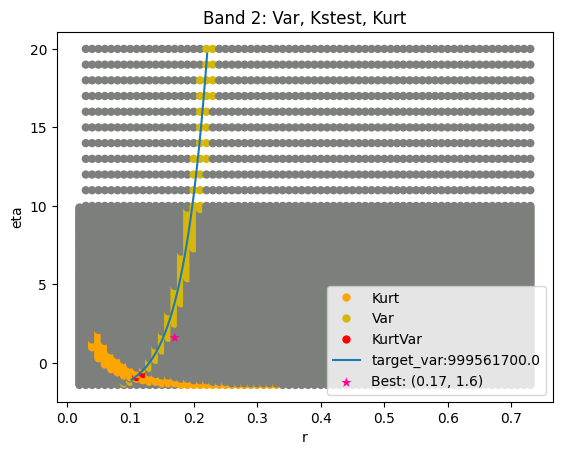

####
Band  5


100%|██████████| 51883/51883 [02:27<00:00, 351.31it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 117000.0


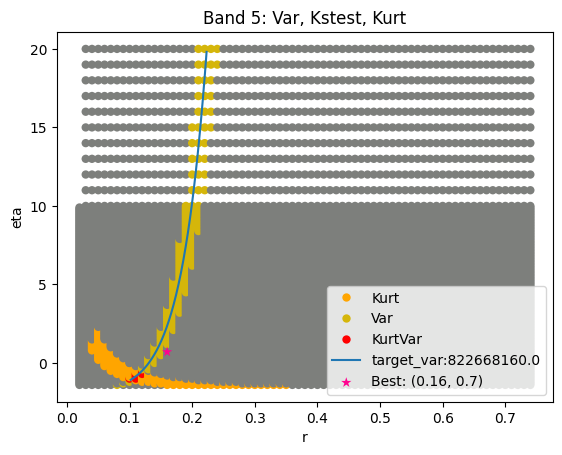

####
Band  8


100%|██████████| 51883/51883 [02:23<00:00, 361.68it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 189000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


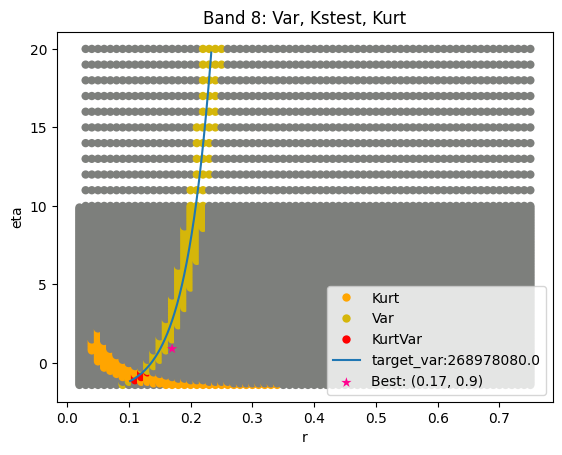

####
Band  11


100%|██████████| 51883/51883 [02:25<00:00, 356.79it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 495000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


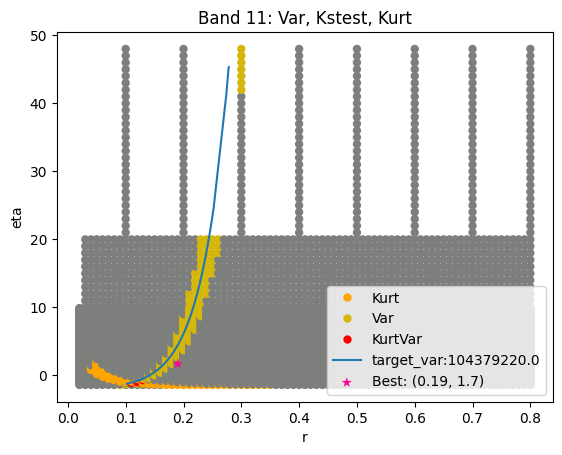

####
Band  14


100%|██████████| 51883/51883 [02:22<00:00, 364.47it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 1134000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


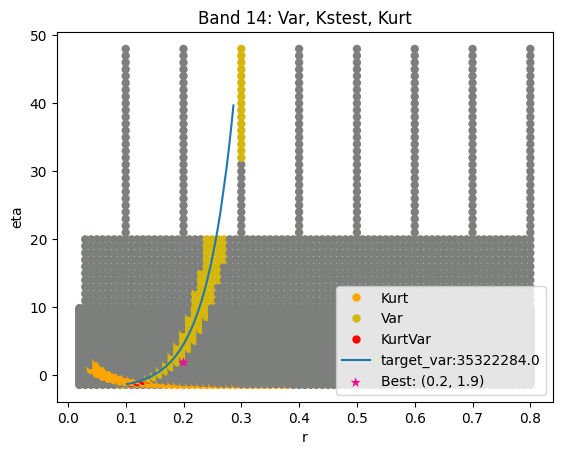

####
Band  17


100%|██████████| 51883/51883 [02:25<00:00, 356.08it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 2574000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


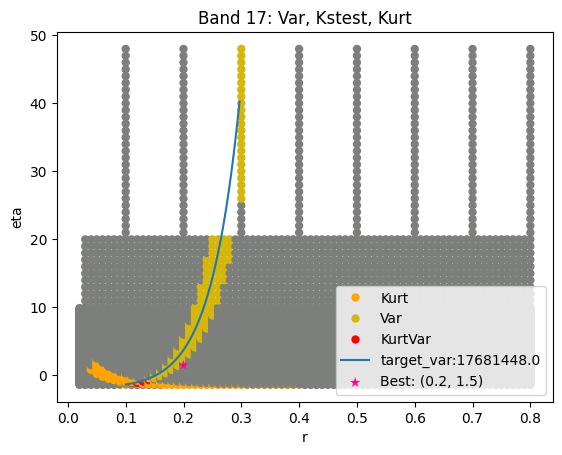

####
Band  20


100%|██████████| 51883/51883 [02:24<00:00, 360.22it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 5967000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


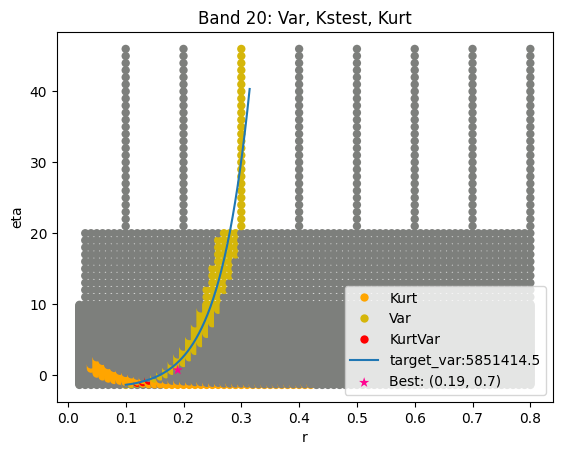

####
Band  23


100%|██████████| 51883/51883 [02:23<00:00, 360.55it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 13887000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


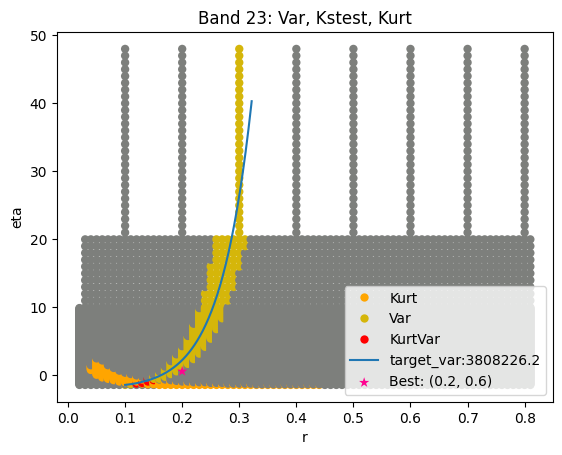

####
Band  26


100%|██████████| 51883/51883 [02:23<00:00, 362.35it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 31968000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


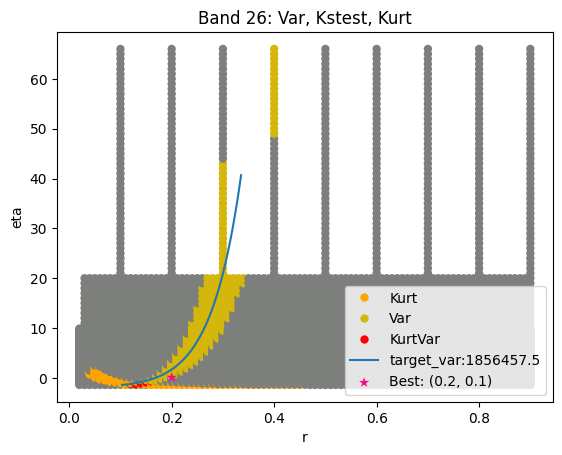

####
Band  29


100%|██████████| 51883/51883 [02:23<00:00, 362.76it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 73701000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


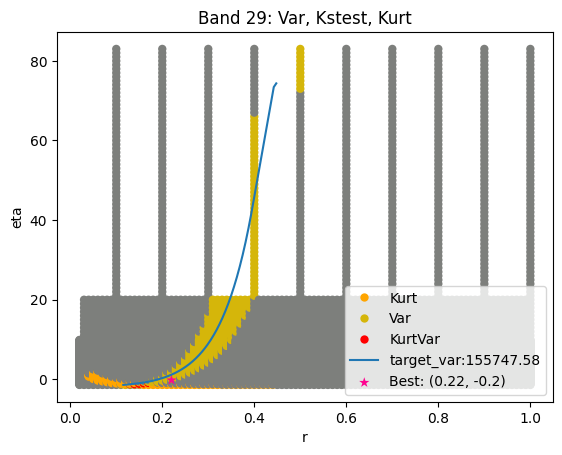

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
band,,,,,,,,,,,
2,9.995617e+08,2.045926e+08,2.628284e+09,2560.448094,254.064946,4885.991133,45000.0,0.17,1.6,0.011757,0.006398
5,8.226682e+08,1.071303e+08,4.312076e+09,11296.462094,211.934169,8693.059848,117000.0,0.16,0.7,0.010626,0.003969
8,2.689781e+08,4.091929e+07,1.513902e+09,12397.882607,231.860427,8746.283018,189000.0,0.17,0.9,0.009357,0.003123
11,1.043792e+08,1.643744e+07,4.774830e+08,7007.382375,198.425173,8168.126969,495000.0,0.19,1.7,0.007428,0.001930
14,3.532228e+07,6.649203e+06,1.551149e+08,6816.936435,155.404677,7821.216677,1134000.0,0.20,1.9,0.007840,0.001275
17,1.768145e+07,3.249794e+06,9.089524e+07,8762.244847,140.549207,8233.500967,2574000.0,0.20,1.5,0.005087,0.000846
20,5.851414e+06,1.784322e+06,2.218287e+07,4678.857771,125.979675,6448.189290,5967000.0,0.19,0.7,0.006414,0.000556
23,3.808226e+06,6.892708e+05,2.682047e+07,16237.410318,112.208868,8765.996131,13887000.0,0.20,0.6,0.009305,0.000364
26,1.856458e+06,1.798568e+05,1.814065e+07,34364.819273,99.133887,9564.747758,31968000.0,0.20,0.1,0.007721,0.000240


In [15]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [16]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 780.21it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 362.09it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 363.72it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 364.62it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 364.66it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 365.60it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 365.59it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 366.30it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 357.83it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 368.16it/s]


Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
band,,,,,,,,,,,,,
2,9.995617e+08,2.045926e+08,2.628284e+09,2560.448094,254.064946,4885.991133,45000.0,0.17,1.6,0.011757,0.006398,0.037097,0.14
5,8.226682e+08,1.071303e+08,4.312076e+09,11296.462094,211.934169,8693.059848,117000.0,0.16,0.7,0.010626,0.003969,0.054908,0.14
8,2.689781e+08,4.091929e+07,1.513902e+09,12397.882607,231.860427,8746.283018,189000.0,0.17,0.9,0.009357,0.003123,0.043110,0.15
11,1.043792e+08,1.643744e+07,4.774830e+08,7007.382375,198.425173,8168.126969,495000.0,0.19,1.7,0.007428,0.001930,0.045988,0.15
14,3.532228e+07,6.649203e+06,1.551149e+08,6816.936435,155.404677,7821.216677,1134000.0,0.20,1.9,0.007840,0.001275,0.046174,0.16
17,1.768145e+07,3.249794e+06,9.089524e+07,8762.244847,140.549207,8233.500967,2574000.0,0.20,1.5,0.005087,0.000846,0.042109,0.16
20,5.851414e+06,1.784322e+06,2.218287e+07,4678.857771,125.979675,6448.189290,5967000.0,0.19,0.7,0.006414,0.000556,0.026138,0.17
23,3.808226e+06,6.892708e+05,2.682047e+07,16237.410318,112.208868,8765.996131,13887000.0,0.20,0.6,0.009305,0.000364,0.023876,0.18
26,1.856458e+06,1.798568e+05,1.814065e+07,34364.819273,99.133887,9564.747758,31968000.0,0.20,0.1,0.007721,0.000240,0.025246,0.20


## Optimization

In [17]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.162, 1.57), 50 of 441
(0.164, 1.65), 100 of 441
(0.167, 1.52), 150 of 441
(0.169, 1.6), 200 of 441
(0.171, 1.68), 250 of 441
(0.174, 1.55), 300 of 441
(0.176, 1.63), 350 of 441
(0.179, 1.5), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 763.52it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 2 best parameters: ((0.169, 1.55), 0.009992888303504224)


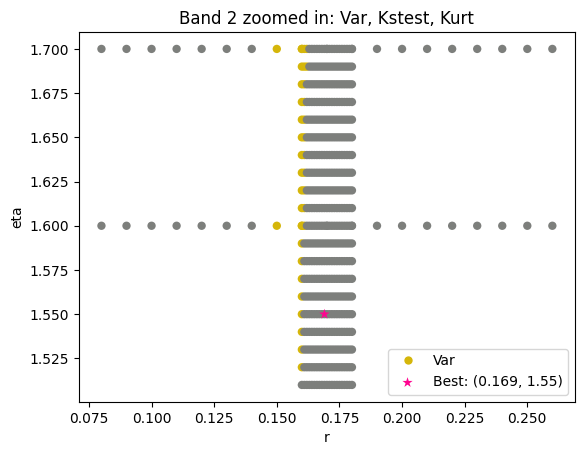

Band 5
(0.152, 0.69), 50 of 420
(0.154, 0.79), 100 of 420
(0.157, 0.69), 150 of 420
(0.159, 0.79), 200 of 420
(0.162, 0.69), 250 of 420
(0.164, 0.79), 300 of 420
(0.167, 0.69), 350 of 420
(0.169, 0.79), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 366.14it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((0.162, 0.79), 0.008443289039321678)


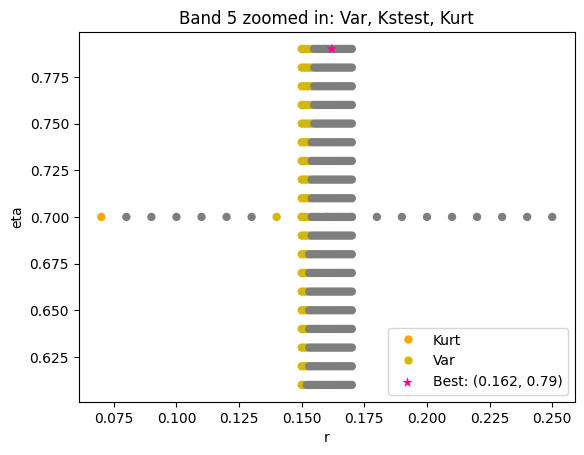

Band 8
(0.162, 0.89), 50 of 420
(0.164, 0.99), 100 of 420
(0.167, 0.89), 150 of 420
(0.169, 0.99), 200 of 420
(0.172, 0.89), 250 of 420
(0.174, 0.99), 300 of 420
(0.177, 0.89), 350 of 420
(0.179, 0.99), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 366.13it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.171, 0.95), 0.008794294099650823)


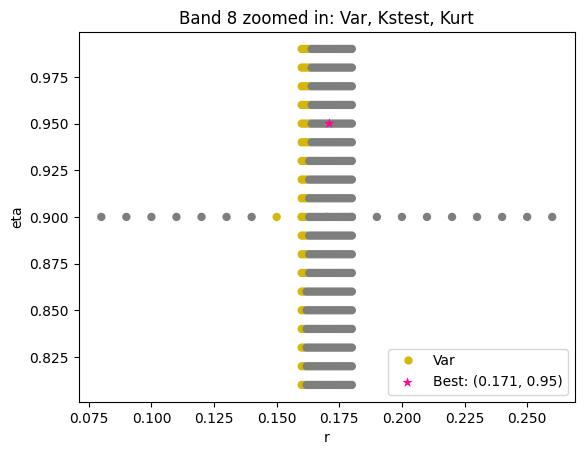

Band 11
(0.182, 1.67), 50 of 441
(0.184, 1.75), 100 of 441
(0.187, 1.62), 150 of 441
(0.189, 1.7), 200 of 441
(0.191, 1.78), 250 of 441
(0.194, 1.65), 300 of 441
(0.196, 1.73), 350 of 441
(0.199, 1.6), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 356.66it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 11 best parameters: ((0.188, 1.63), 0.005684060827510313)


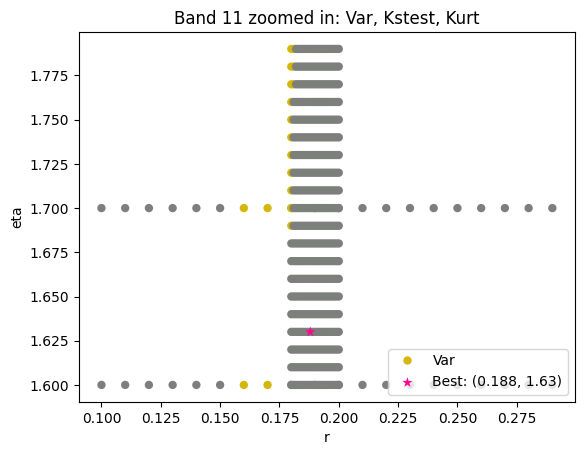

Band 14
(0.192, 1.87), 50 of 441
(0.194, 1.95), 100 of 441
(0.197, 1.82), 150 of 441
(0.199, 1.9), 200 of 441
(0.201, 1.98), 250 of 441
(0.204, 1.85), 300 of 441
(0.206, 1.93), 350 of 441
(0.209, 1.8), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 367.55it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 14 best parameters: ((0.198, 1.84), 0.004870059237923274)


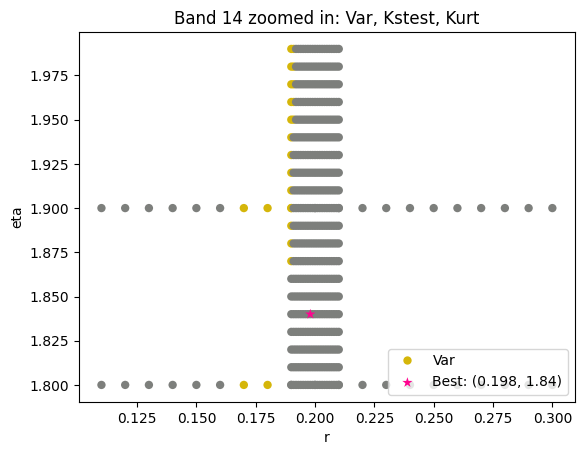

Band 17
(0.192, 1.47), 50 of 441
(0.194, 1.55), 100 of 441
(0.197, 1.42), 150 of 441
(0.199, 1.5), 200 of 441
(0.201, 1.58), 250 of 441
(0.204, 1.45), 300 of 441
(0.206, 1.53), 350 of 441
(0.209, 1.4), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 366.01it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 17 best parameters: ((0.198, 1.42), 0.0036121694695424)


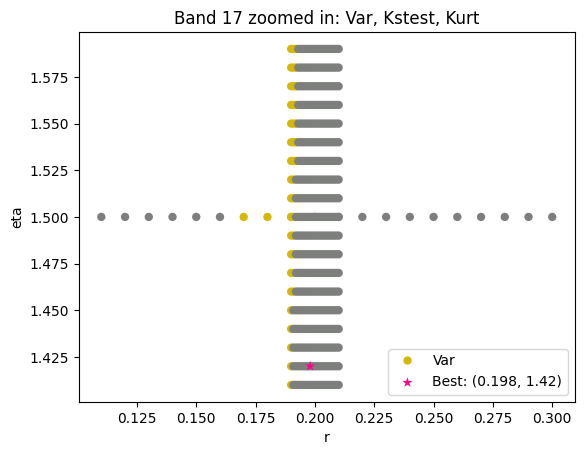

Band 20
(0.182, 0.69), 50 of 420
(0.184, 0.79), 100 of 420
(0.187, 0.69), 150 of 420
(0.189, 0.79), 200 of 420
(0.192, 0.69), 250 of 420
(0.194, 0.79), 300 of 420
(0.197, 0.69), 350 of 420
(0.199, 0.79), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 357.21it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.192, 0.77), 0.0043534048246720025)


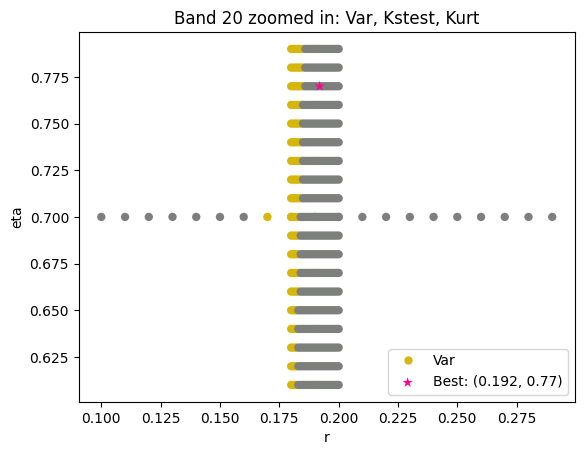

Band 23
(0.192, 0.59), 50 of 420
(0.194, 0.69), 100 of 420
(0.197, 0.59), 150 of 420
(0.199, 0.69), 200 of 420
(0.202, 0.59), 250 of 420
(0.204, 0.69), 300 of 420
(0.207, 0.59), 350 of 420
(0.209, 0.69), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 363.75it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.198, 0.57), 0.005799387735740333)


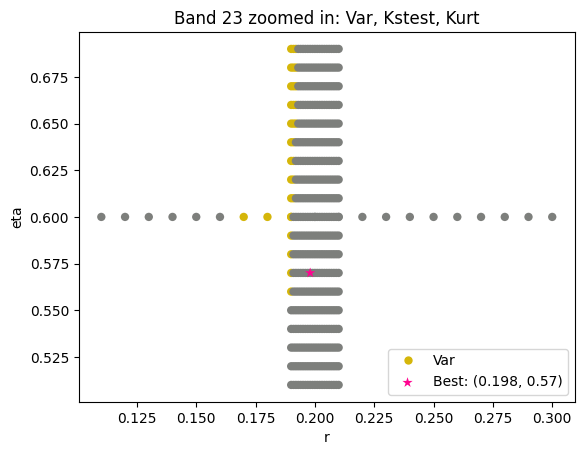

Band 26
(0.192, 0.09), 50 of 420
(0.194, 0.19), 100 of 420
(0.197, 0.09), 150 of 420
(0.199, 0.19), 200 of 420
(0.202, 0.09), 250 of 420
(0.204, 0.19), 300 of 420
(0.207, 0.09), 350 of 420
(0.209, 0.19), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 364.41it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 26 best parameters: ((0.201, 0.12), 0.006598692265486816)


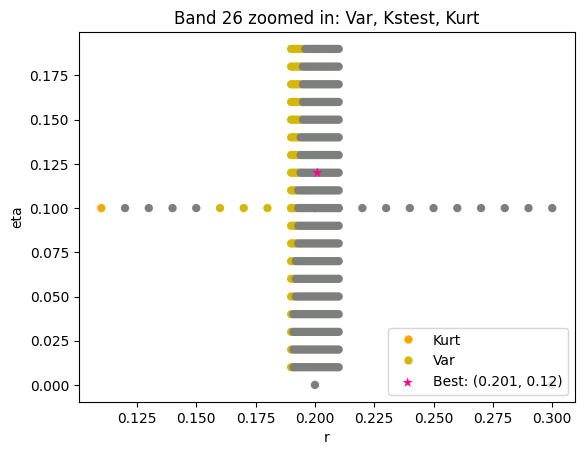

Band 29
(0.212, -0.23), 50 of 441
(0.214, -0.15), 100 of 441
(0.217, -0.28), 150 of 441
(0.219, -0.2), 200 of 441
(0.221, -0.12), 250 of 441
(0.224, -0.25), 300 of 441
(0.226, -0.17), 350 of 441
(0.229, -0.3), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 357.12it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 29 best parameters: ((0.218, -0.26), 0.010885900694300954)


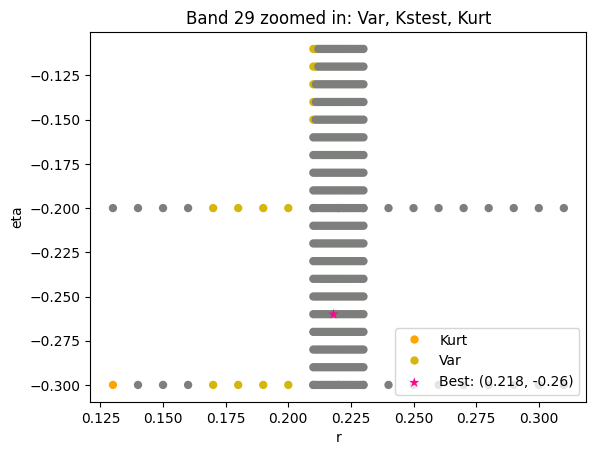

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,9.995617e+08,2.045926e+08,2.628284e+09,2560.448094,254.064946,4885.991133,45000.0,0.17,1.6,0.011757,0.006398,0.037097,0.14,0.169,1.55,0.009993,0.169,1.55,0.009993,18984
5,8.226682e+08,1.071303e+08,4.312076e+09,11296.462094,211.934169,8693.059848,117000.0,0.16,0.7,0.010626,0.003969,0.054908,0.14,0.162,0.79,0.008443,0.162,0.79,0.008443,24678
8,2.689781e+08,4.091929e+07,1.513902e+09,12397.882607,231.860427,8746.283018,189000.0,0.17,0.9,0.009357,0.003123,0.043110,0.15,0.171,0.95,0.008794,0.171,0.95,0.008794,23625
11,1.043792e+08,1.643744e+07,4.774830e+08,7007.382375,198.425173,8168.126969,495000.0,0.19,1.7,0.007428,0.001930,0.045988,0.15,0.188,1.63,0.005684,0.188,1.63,0.005684,58729
14,3.532228e+07,6.649203e+06,1.551149e+08,6816.936435,155.404677,7821.216677,1134000.0,0.20,1.9,0.007840,0.001275,0.046174,0.16,0.198,1.84,0.004870,0.198,1.84,0.004870,79734
17,1.768145e+07,3.249794e+06,9.089524e+07,8762.244847,140.549207,8233.500967,2574000.0,0.20,1.5,0.005087,0.000846,0.042109,0.16,0.198,1.42,0.003612,0.198,1.42,0.003612,135736
20,5.851414e+06,1.784322e+06,2.218287e+07,4678.857771,125.979675,6448.189290,5967000.0,0.19,0.7,0.006414,0.000556,0.026138,0.17,0.192,0.77,0.004353,0.192,0.77,0.004353,93234
23,3.808226e+06,6.892708e+05,2.682047e+07,16237.410318,112.208868,8765.996131,13887000.0,0.20,0.6,0.009305,0.000364,0.023876,0.18,0.198,0.57,0.005799,0.198,0.57,0.005799,54246
26,1.856458e+06,1.798568e+05,1.814065e+07,34364.819273,99.133887,9564.747758,31968000.0,0.20,0.1,0.007721,0.000240,0.025246,0.20,0.201,0.12,0.006599,0.201,0.12,0.006599,44446


In [18]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

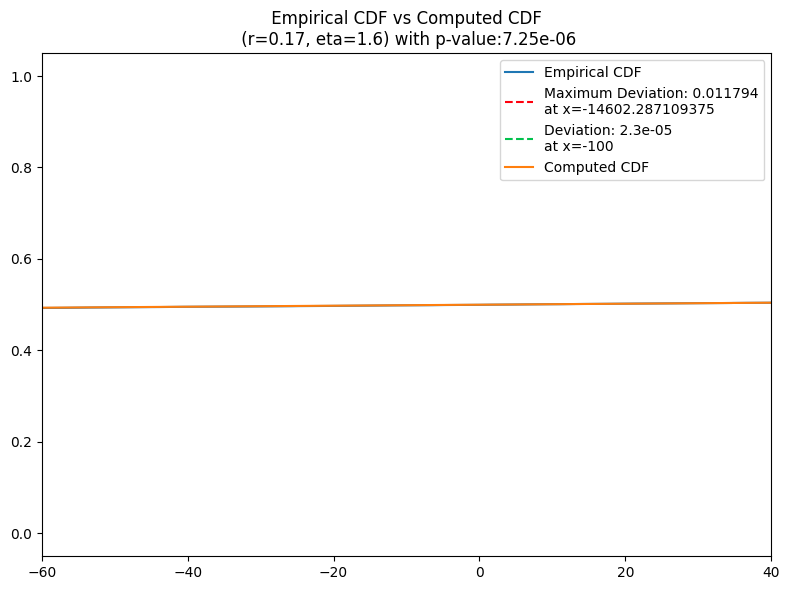

In [19]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

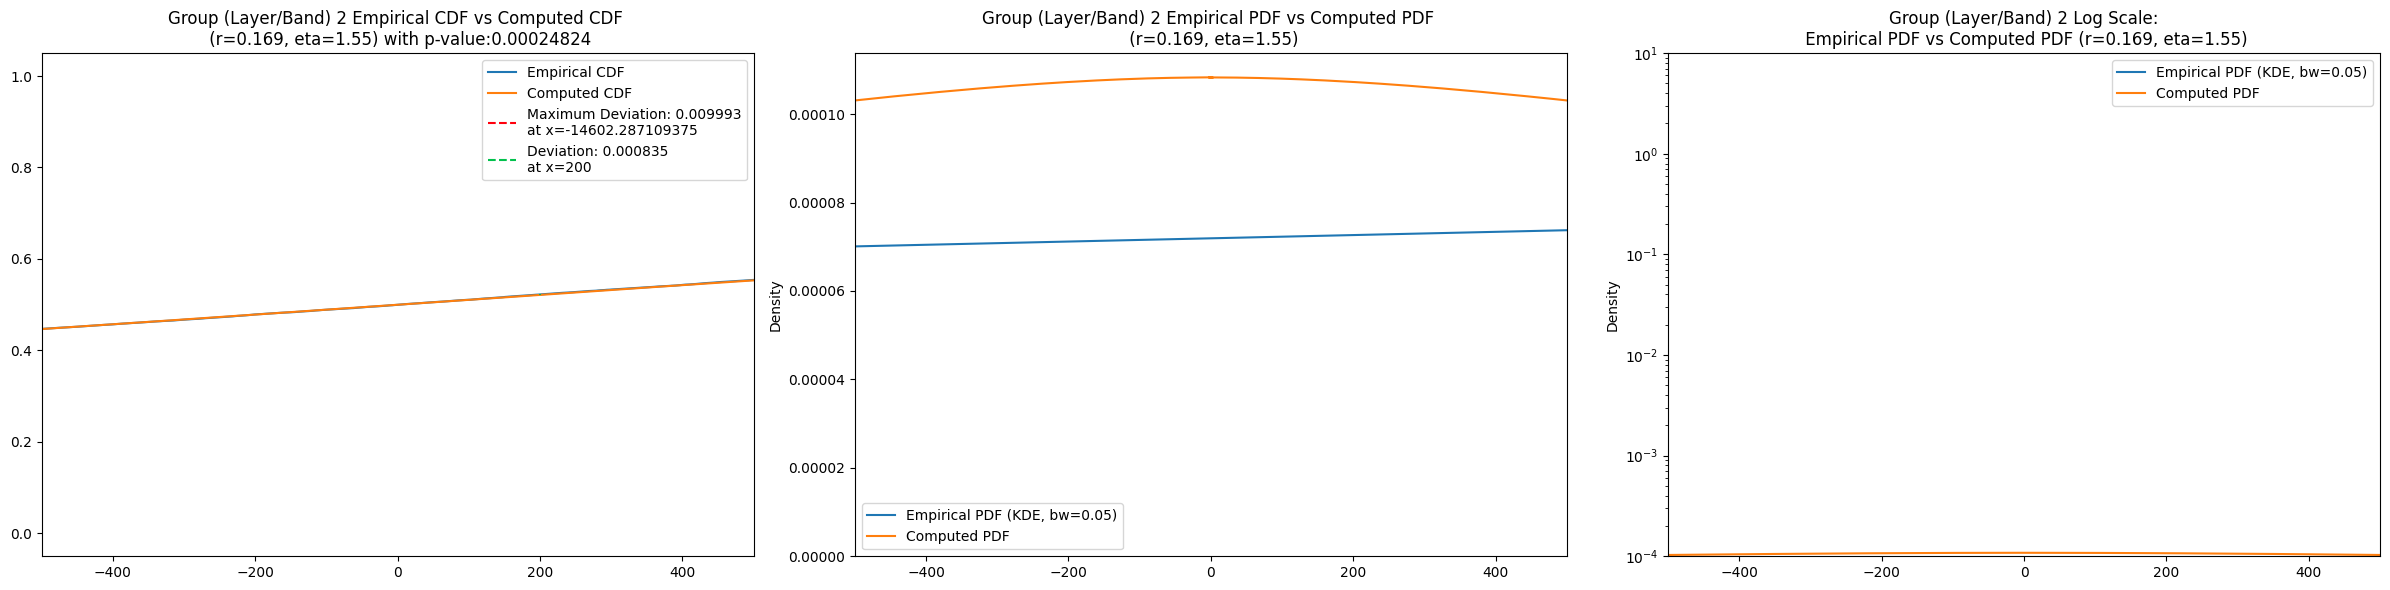

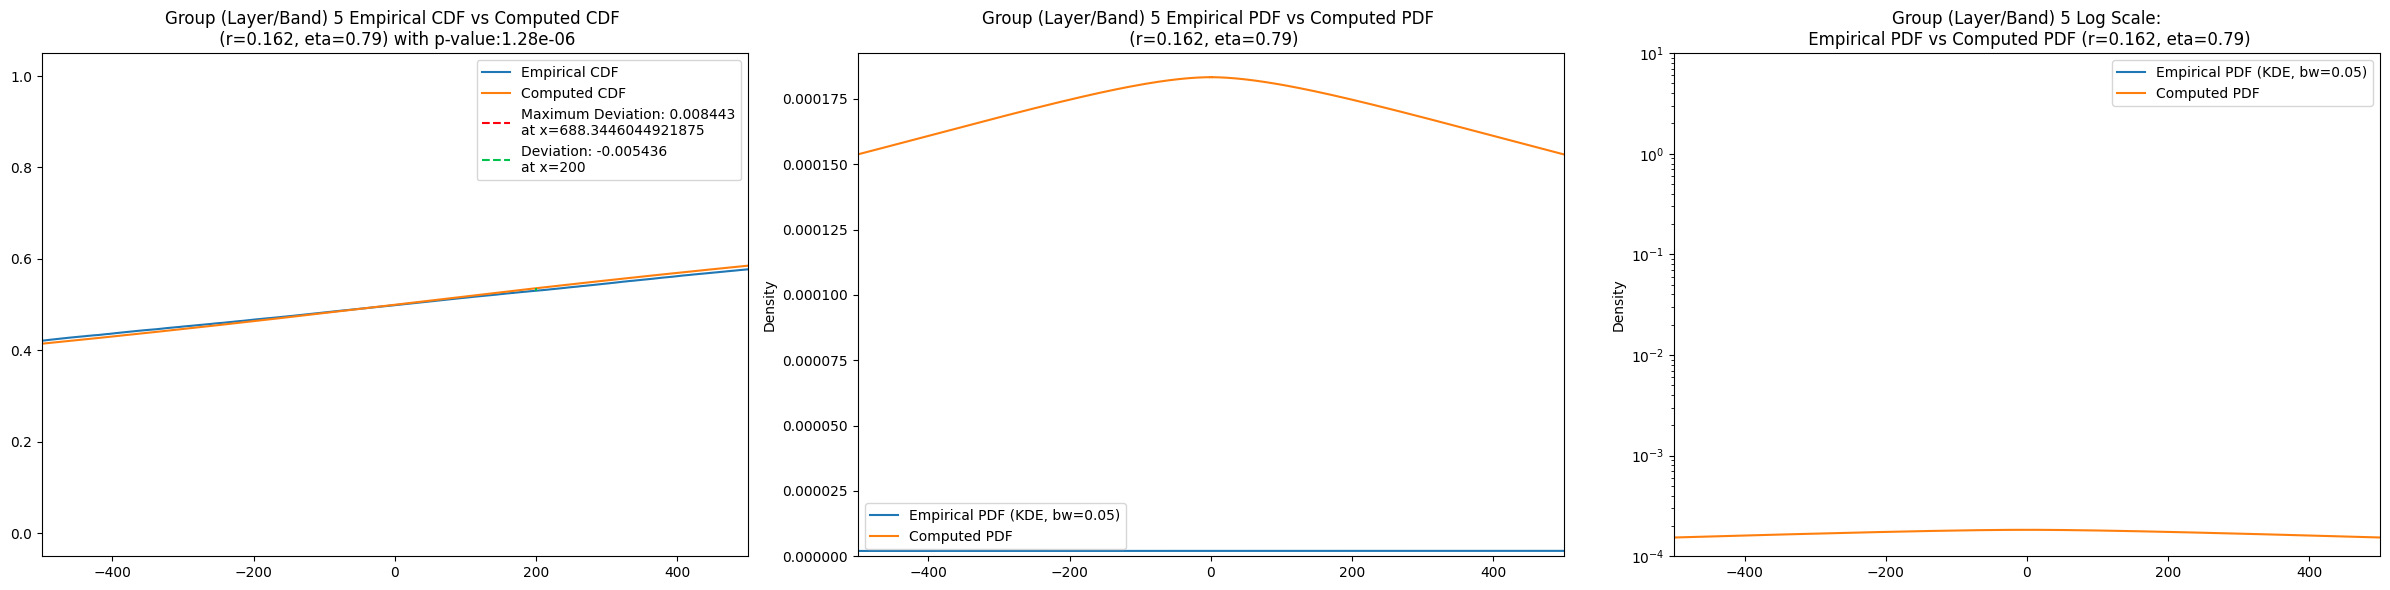

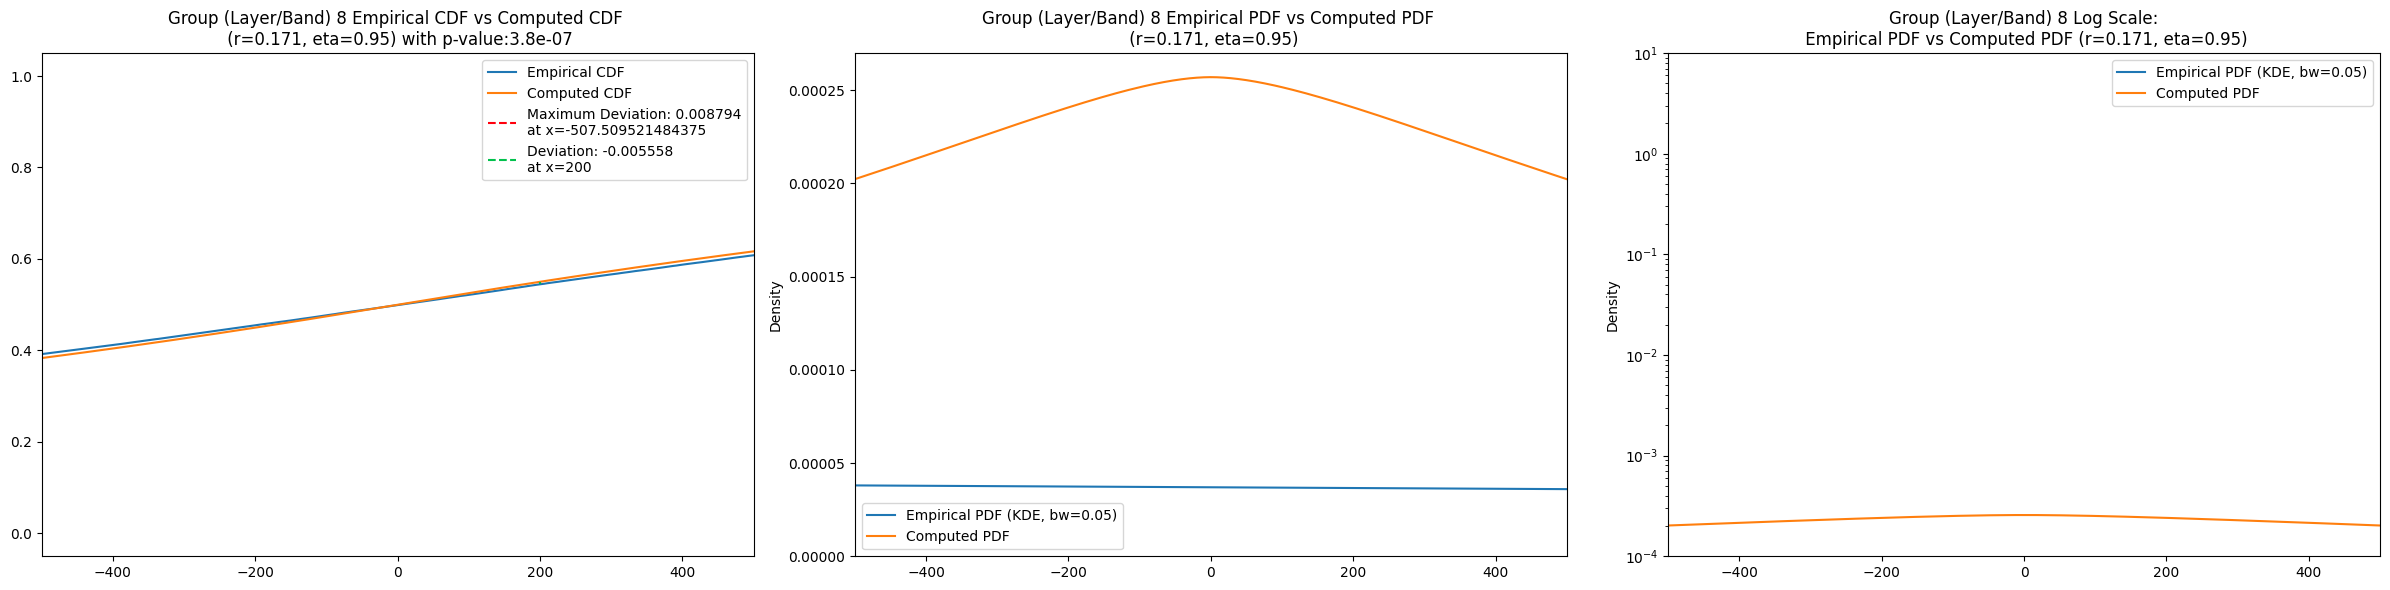

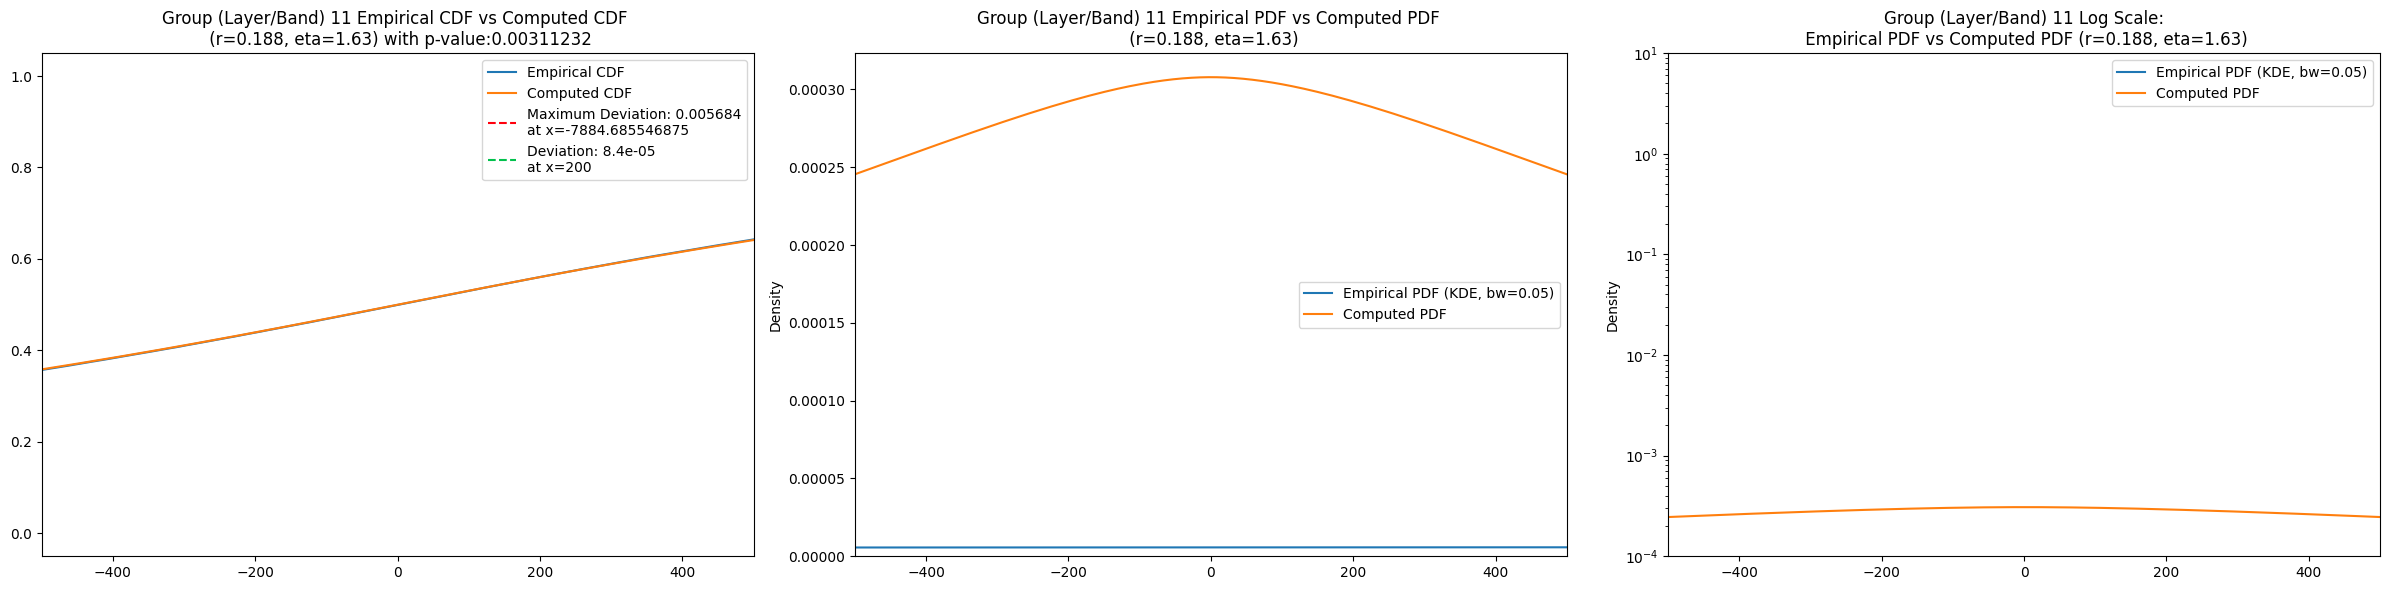

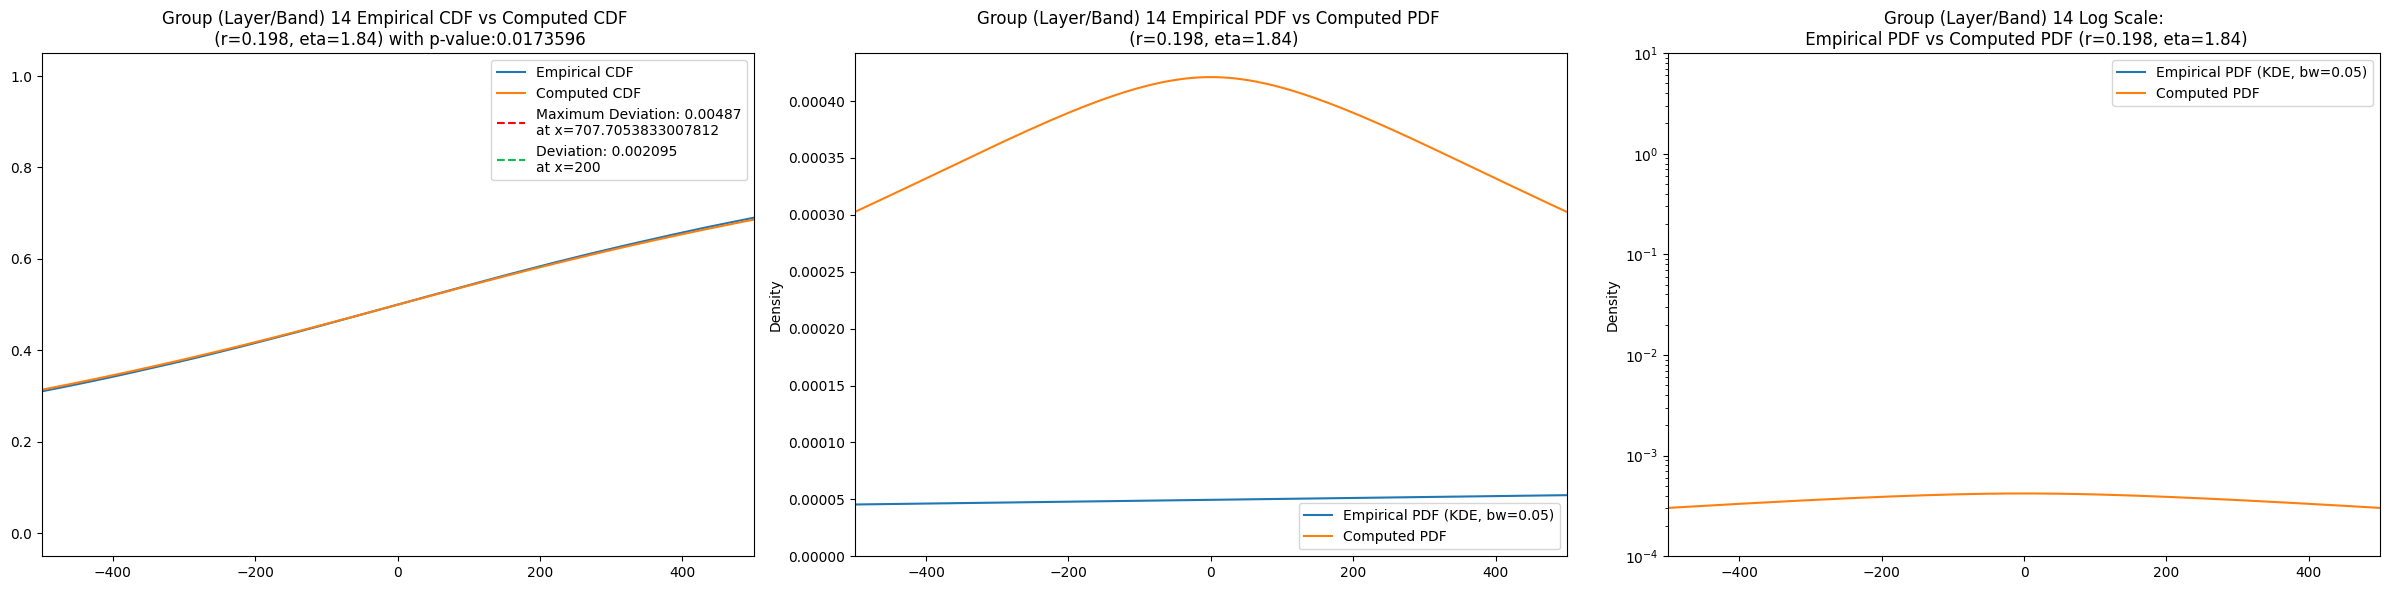

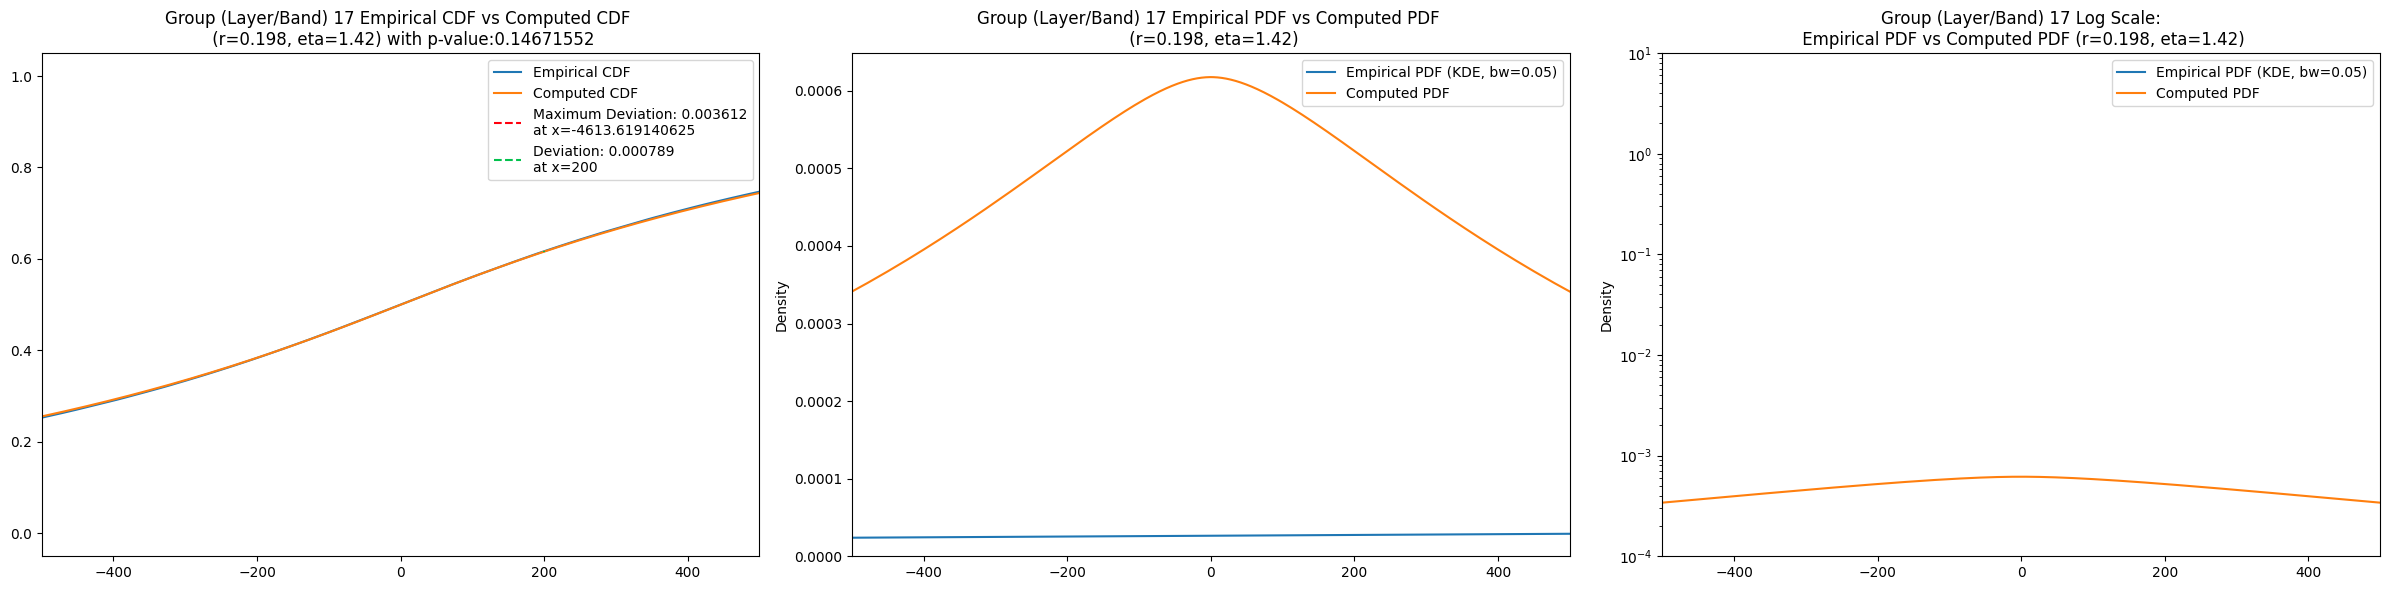

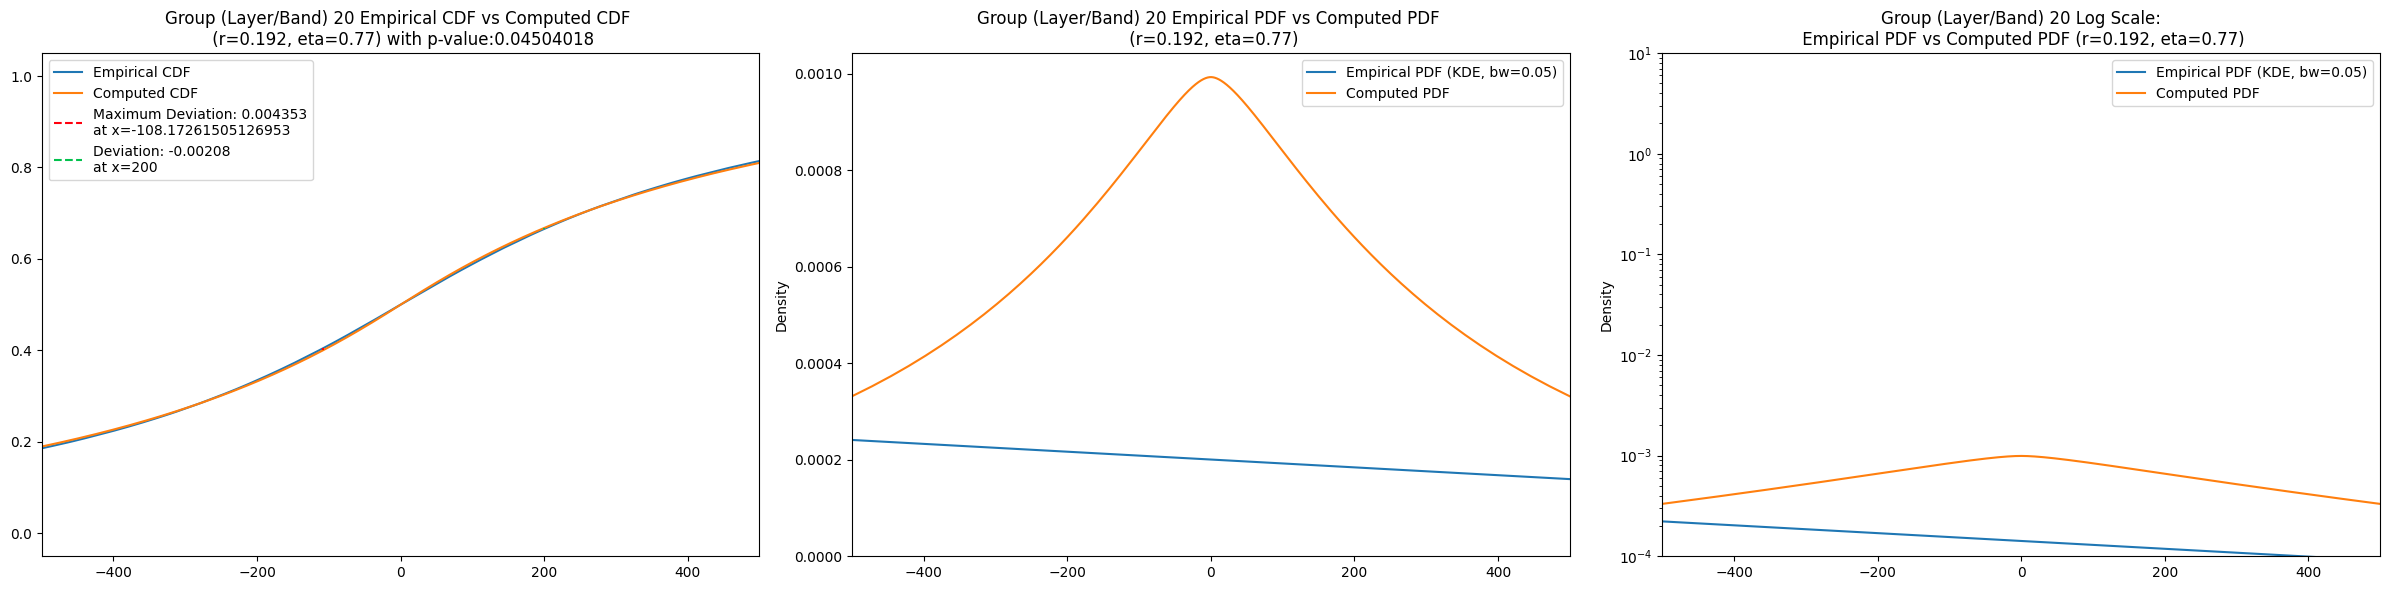

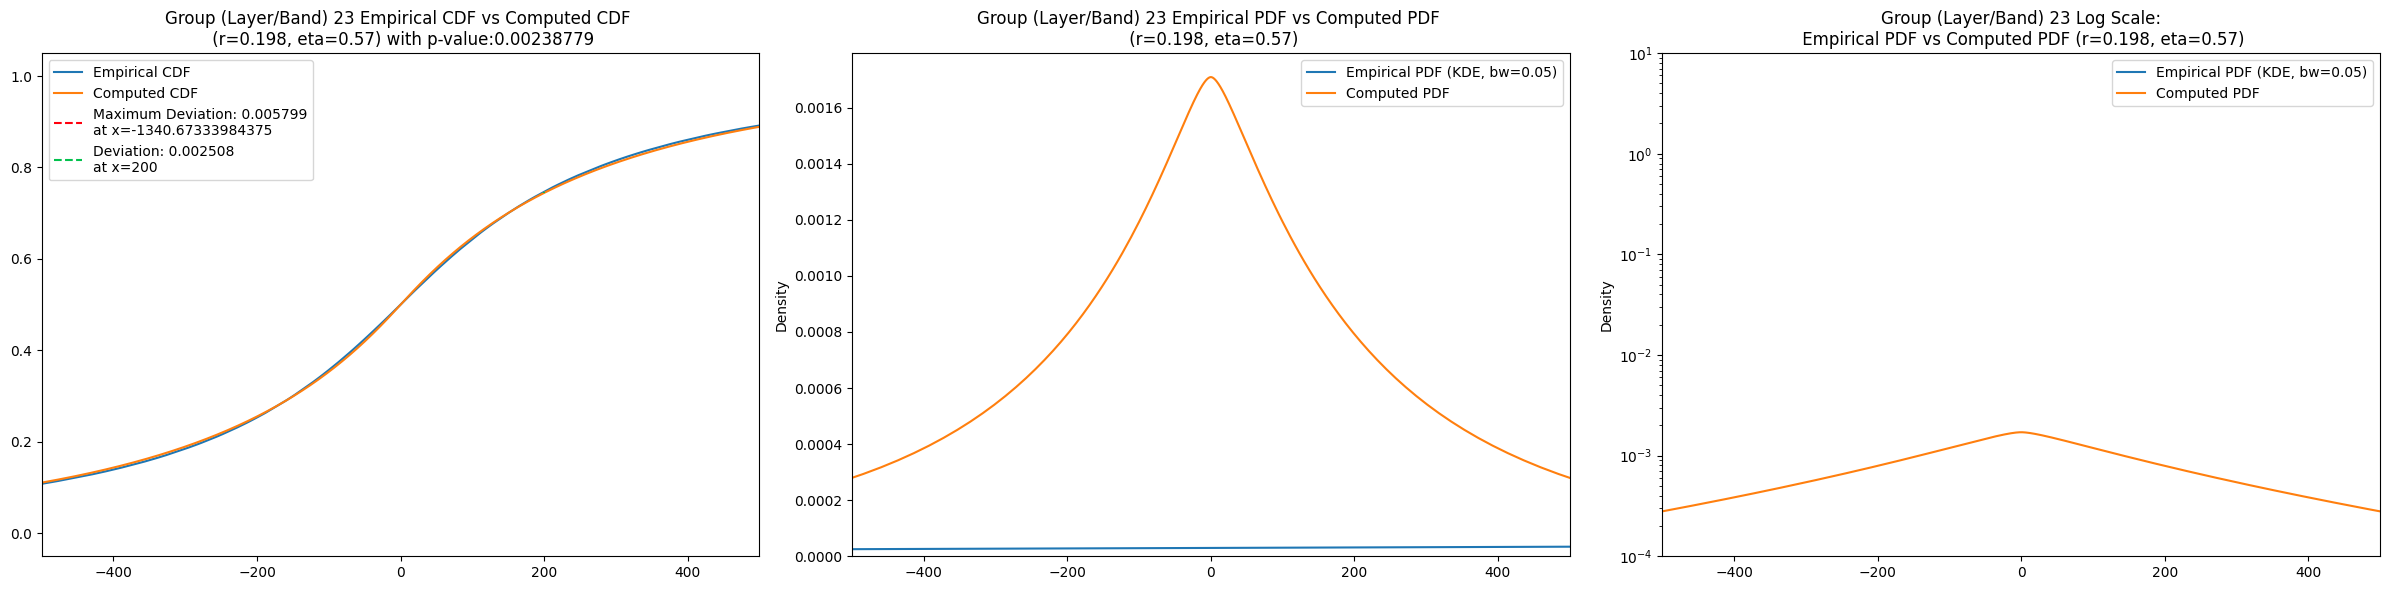

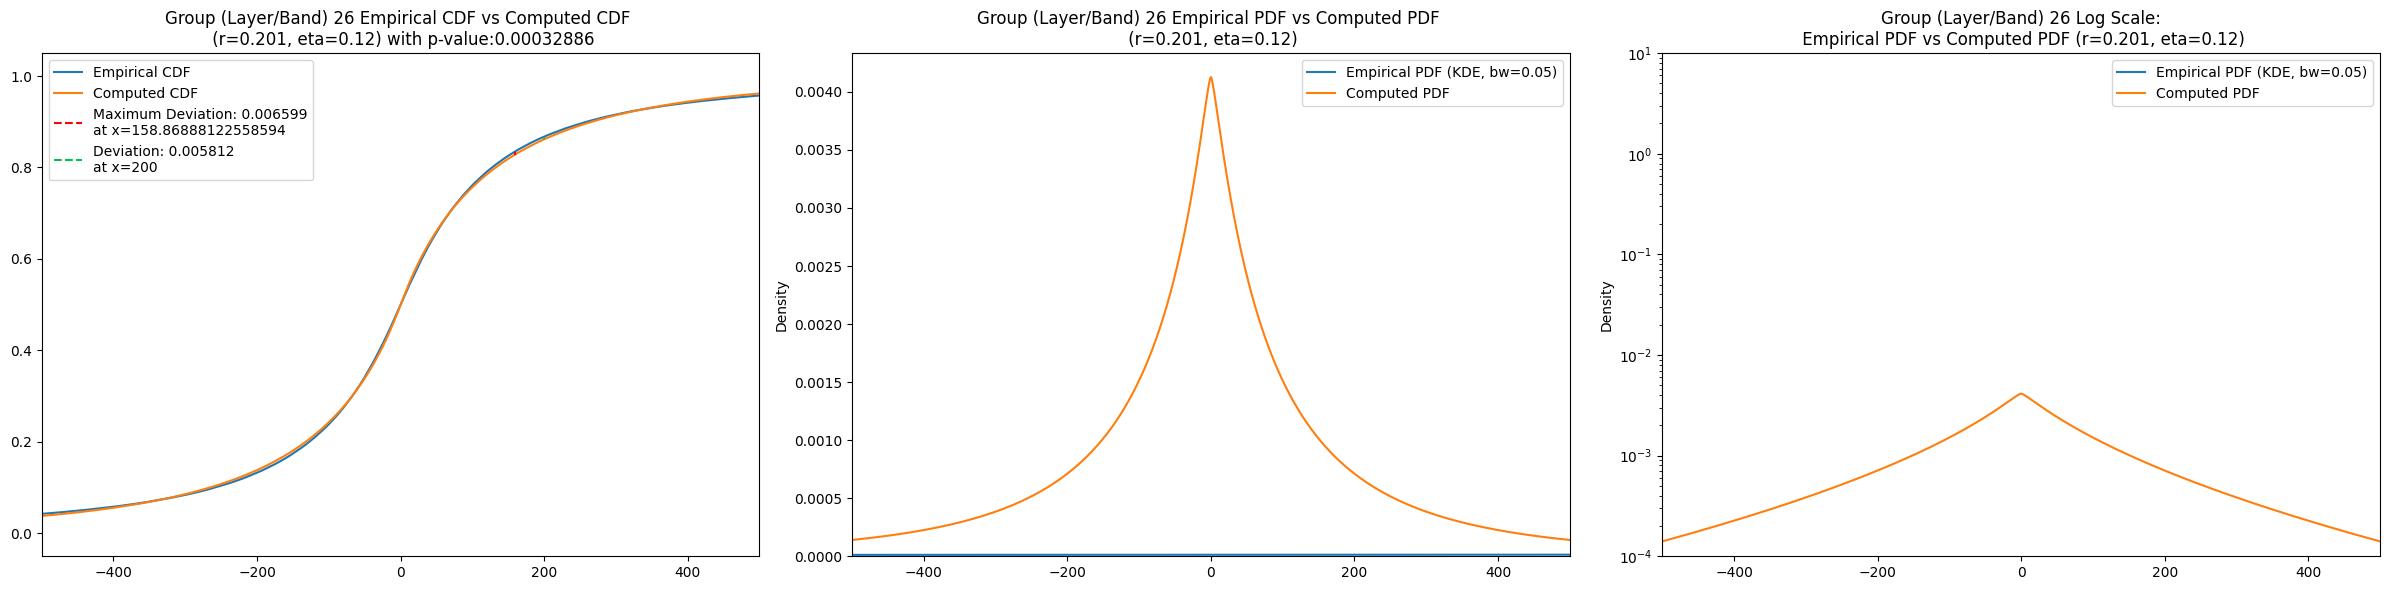

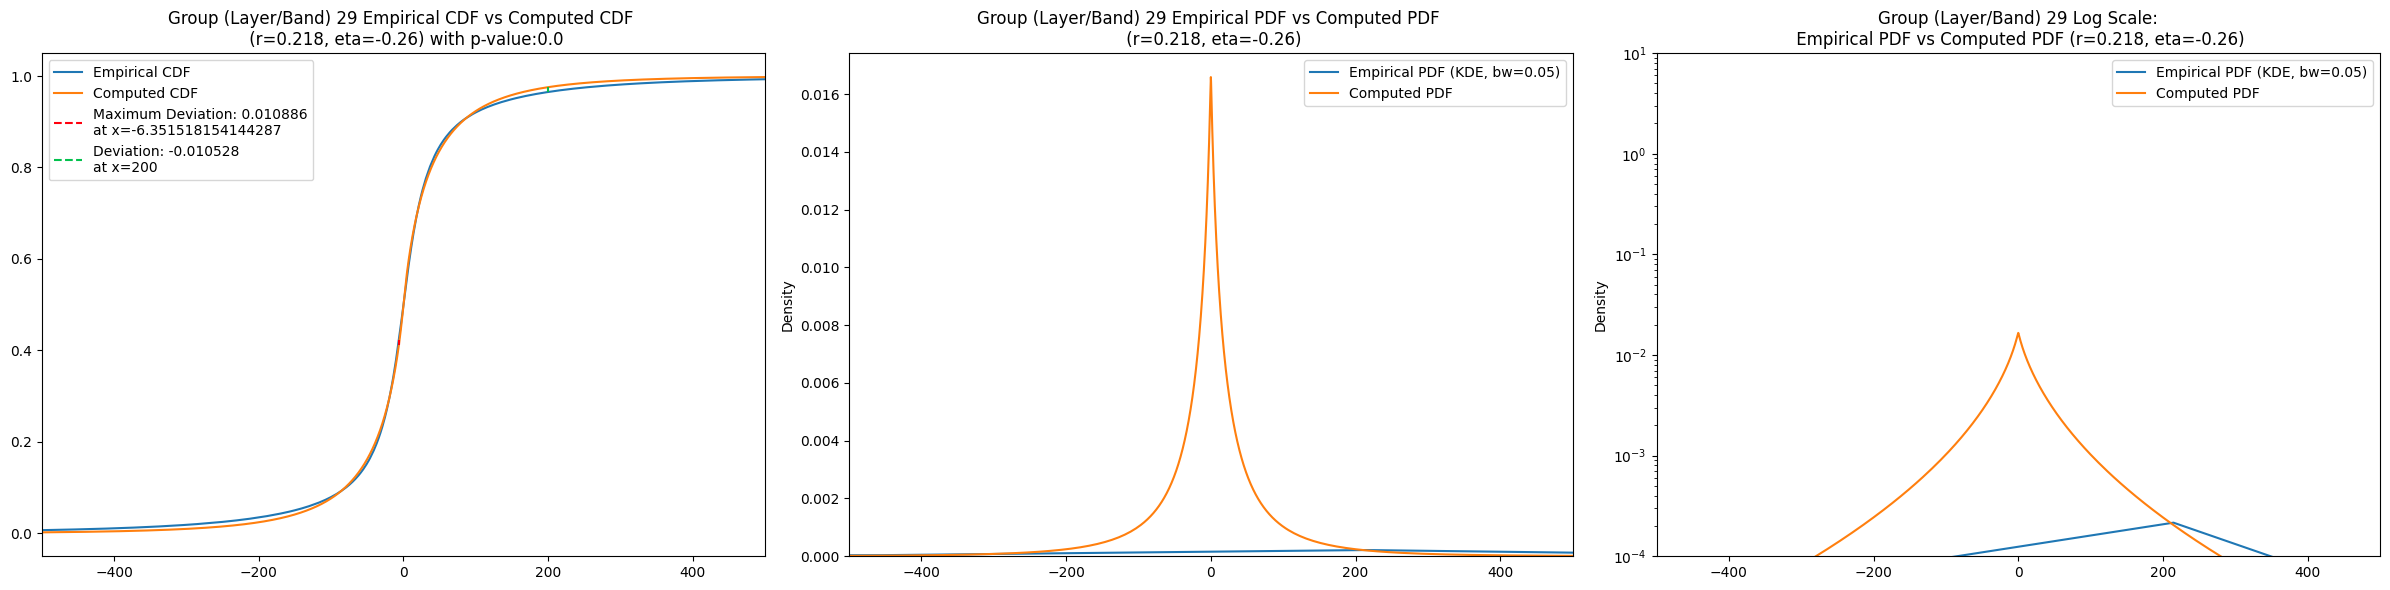

In [20]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [21]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [22]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,9.995617e+08,2.045926e+08,2.628284e+09,2560.448094,254.064946,4885.991133,45000.0,0.17,1.6,0.011757,...,5164.9000,0.043530,1.568350e-74,4579.5300,0.018696,4.284210e-14,3625.2600,0.013893,5.661940e-08,2.482998e-04
5,8.226682e+08,1.071303e+08,4.312076e+09,11296.462094,211.934169,8693.059848,117000.0,0.16,0.7,0.010626,...,3541.5500,0.041911,5.173600e-179,3147.1000,0.018333,1.377460e-34,2498.4400,0.011667,2.913580e-14,1.131705e-07
8,2.689781e+08,4.091929e+07,1.513902e+09,12397.882607,231.860427,8746.283018,189000.0,0.17,0.9,0.009357,...,2388.6700,0.036823,4.244110e-223,2104.6400,0.013500,2.390620e-30,1696.7600,0.006872,3.510720e-08,3.999023e-13
11,1.043792e+08,1.643744e+07,4.774830e+08,7007.382375,198.425173,8168.126969,495000.0,0.19,1.7,0.007428,...,1738.7300,0.034148,0.000000e+00,1537.4400,0.010780,2.151100e-50,1238.8100,0.005728,1.554490e-14,2.559653e-14
14,3.532228e+07,6.649203e+06,1.551149e+08,6816.936435,155.404677,7821.216677,1134000.0,0.20,1.9,0.007840,...,1232.5200,0.033046,0.000000e+00,1085.3600,0.008683,1.074800e-74,884.3610,0.005843,4.722080e-34,8.677252e-24
17,1.768145e+07,3.249794e+06,9.089524e+07,8762.244847,140.549207,8233.500967,2574000.0,0.20,1.5,0.005087,...,880.8260,0.034778,0.000000e+00,774.3440,0.009442,9.977010e-200,627.8450,0.007057,9.247870e-112,1.344195e-29
20,5.851414e+06,1.784322e+06,2.218287e+07,4678.857771,125.979675,6448.189290,5967000.0,0.19,0.7,0.006414,...,611.4400,0.039967,0.000000e+00,538.8820,0.014457,0.000000e+00,432.9790,0.010522,0.000000e+00,1.183909e-98
23,3.808226e+06,6.892708e+05,2.682047e+07,16237.410318,112.208868,8765.996131,13887000.0,0.20,0.6,0.009305,...,369.4480,0.042902,0.000000e+00,326.6100,0.017984,0.000000e+00,260.6760,0.012713,0.000000e+00,0.000000e+00
26,1.856458e+06,1.798568e+05,1.814065e+07,34364.819273,99.133887,9564.747758,31968000.0,0.20,0.1,0.007721,...,173.0270,0.048450,0.000000e+00,153.9990,0.023325,0.000000e+00,121.3180,0.018486,0.000000e+00,0.000000e+00


In [23]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [24]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [25]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,9.995617e+08,2.045926e+08,2.628284e+09,2560.448094,254.064946,4885.991133,45000.0,0.17,1.6,0.011757,...,5164.9000,0.043530,1.568350e-74,4579.5300,0.018696,4.284210e-14,3625.2600,0.013893,5.661940e-08,2.482998e-04
5,8.226682e+08,1.071303e+08,4.312076e+09,11296.462094,211.934169,8693.059848,117000.0,0.16,0.7,0.010626,...,3541.5500,0.041911,5.173600e-179,3147.1000,0.018333,1.377460e-34,2498.4400,0.011667,2.913580e-14,1.131705e-07
8,2.689781e+08,4.091929e+07,1.513902e+09,12397.882607,231.860427,8746.283018,189000.0,0.17,0.9,0.009357,...,2388.6700,0.036823,4.244110e-223,2104.6400,0.013500,2.390620e-30,1696.7600,0.006872,3.510720e-08,3.999023e-13
11,1.043792e+08,1.643744e+07,4.774830e+08,7007.382375,198.425173,8168.126969,495000.0,0.19,1.7,0.007428,...,1738.7300,0.034148,0.000000e+00,1537.4400,0.010780,2.151100e-50,1238.8100,0.005728,1.554490e-14,2.559653e-14
14,3.532228e+07,6.649203e+06,1.551149e+08,6816.936435,155.404677,7821.216677,1134000.0,0.20,1.9,0.007840,...,1232.5200,0.033046,0.000000e+00,1085.3600,0.008683,1.074800e-74,884.3610,0.005843,4.722080e-34,8.677252e-24
17,1.768145e+07,3.249794e+06,9.089524e+07,8762.244847,140.549207,8233.500967,2574000.0,0.20,1.5,0.005087,...,880.8260,0.034778,0.000000e+00,774.3440,0.009442,9.977010e-200,627.8450,0.007057,9.247870e-112,1.344195e-29
20,5.851414e+06,1.784322e+06,2.218287e+07,4678.857771,125.979675,6448.189290,5967000.0,0.19,0.7,0.006414,...,611.4400,0.039967,0.000000e+00,538.8820,0.014457,0.000000e+00,432.9790,0.010522,0.000000e+00,1.183909e-98
23,3.808226e+06,6.892708e+05,2.682047e+07,16237.410318,112.208868,8765.996131,13887000.0,0.20,0.6,0.009305,...,369.4480,0.042902,0.000000e+00,326.6100,0.017984,0.000000e+00,260.6760,0.012713,0.000000e+00,0.000000e+00
26,1.856458e+06,1.798568e+05,1.814065e+07,34364.819273,99.133887,9564.747758,31968000.0,0.20,0.1,0.007721,...,173.0270,0.048450,0.000000e+00,153.9990,0.023325,0.000000e+00,121.3180,0.018486,0.000000e+00,0.000000e+00
